In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import os
from joblib import dump, load
from PIL import Image
from tqdm.notebook import tqdm
from torch.nn.functional import relu
from torch.utils.data import DataLoader, Dataset
from SHG import SHG
from utils import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

In [ ]:
def create_data(train_dataloader, device, model, NUM_DATAPOINTS):
    """ Finds NUM_DATAPOINTS from train_dataloader of fully annotated images """
    bottleneck_arr = []
    gt_heatmaps = []
    model.eval()

    with torch.no_grad():
        for x, y, id_ in tqdm(train_dataloader, total = NUM_DATAPOINTS):
            x = x.to(device, dtype = torch.float)

            _, bottleneck = model(x)

            if (0 in np.array(turn_featuremaps_to_keypoints(y)).reshape((-1, 3))[:, -1]):
                continue

            bottleneck_arr.append(bottleneck[2].cpu().data.numpy().flatten())
            gt_heatmaps.append(turn_featuremaps_to_keypoints(y))

            if (len(bottleneck_arr) == NUM_DATAPOINTS):
                break

    bottleneck_arr = np.array(bottleneck_arr).reshape((len(bottleneck_arr), -1))
    gt_heatmaps = np.array(gt_heatmaps).reshape((len(gt_heatmaps), -1))

    return bottleneck_arr, gt_heatmaps

In [3]:
""" PATHS """
# Bottleneck data path
DATA_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/data/"

# Ground truth heatmaps
HEATMAPS_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/train/heatmaps/"

# Path for model
MODEL_DIR = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/models/Mon_Apr_12_18-11-59_2021/epoch_46.pth"

# Path for mean rgb
average_rgb = np.loadtxt("./average_rgb.npy")

# Saving path
SAVING_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space/"
FIG_SAVING_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/"

In [ ]:
""" DATASET AND DATALOADER """

class dataset(Dataset):
    def __init__(self, X_path, y_path, average_rgb):
        self.X_path = X_path
        self.y_path = y_path
        self.X_data = os.listdir(self.X_path)
        self.average_rgb = average_rgb
        self.norm = transforms.Normalize(mean = self.average_rgb, std = [1, 1, 1])

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, i):
        ID = self.X_data[i]
        x = Image.open(self.X_path + ID)

        y = []

        for i in range(17):
            y.append(torch.from_numpy(np.load(self.y_path + ID[:-4] + "/" + str(i) + ".npy")))

        x = TF.to_tensor(x)

        if (x.shape[0] == 1): # If the image is gray-scale, cast it to rgb
            x = torch.stack((x[0],) * 3)

        x = self.norm(x) # Subtracts mean rgb

        y = torch.stack(y)
        return x, y, ID

train_data = dataset(TRAIN_IMGS_PATH, TRAIN_HEATMAPS_PATH, average_rgb)
train_dataloader = DataLoader(train_data, batch_size = 1, shuffle = True)

In [ ]:
""" LOADING MODEL """
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SHG(num_hourglasses = 1, use_skip_connections = False).to(device)
model.load_state_dict(torch.load(MODEL_DIR))
model.eval()
print()

In [ ]:
X, y = create_data(train_dataloader, device, model, -1)

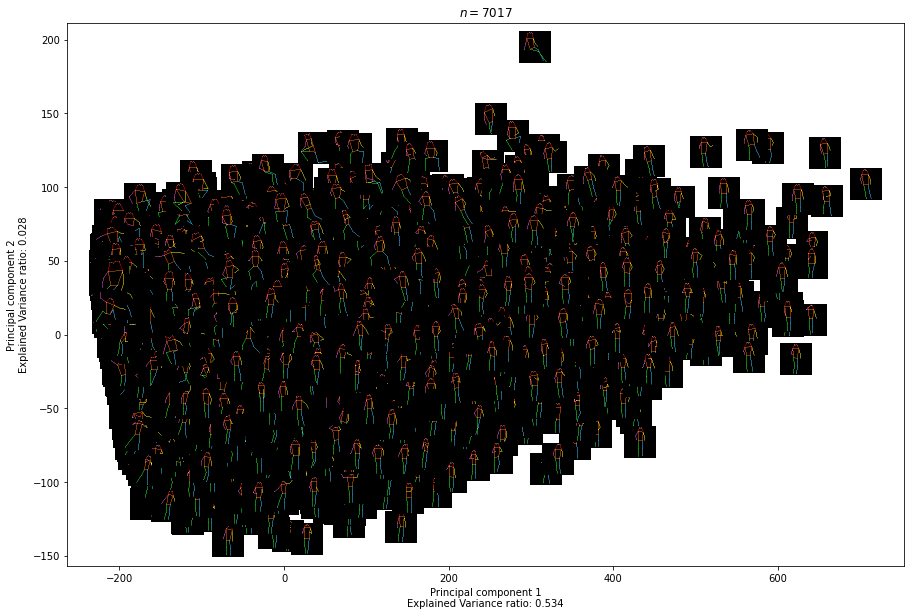

In [8]:
""" Visualizing latent space """
pca = PCA(n_components=2).fit(X)
X_transformed = pca.transform(X)

fig, ax = plt.subplots(figsize = (15, 10))

ax.set_xlabel("Principal component 1\nExplained Variance ratio: {:.3f}".format(pca.explained_variance_ratio_[0]))
ax.set_ylabel("Principal component 2\nExplained Variance ratio: {:.3f}".format(pca.explained_variance_ratio_[1]))

for x, y_ in zip(X_transformed, y):
    y_ = turn_featuremaps_to_keypoints(y_)
    image = draw_skeleton(y_)
    im = OffsetImage(image, zoom = 0.5)
    ab = AnnotationBbox(im, (x[0], x[1]), xycoords = "data", frameon = False)
    ax.add_artist(ab)
    ax.update_datalim([(x[0], x[1])])
    ax.autoscale()

plt.title("$n =${}".format(len(X_transformed)))
plt.savefig(FIG_SAVING_PATH + "latent_space_full_skeletons.png")
plt.show()

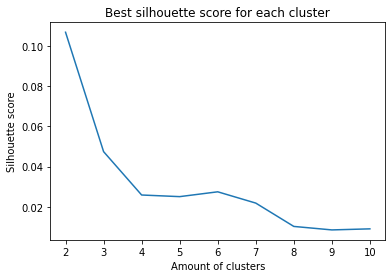

In [9]:
""" First we run KMeans on all of the data"""
kmeans_full_model, centroids_full, labels = get_kmeans_alternative(StandardScaler().fit_transform(X), max_k = 10, fig_saving_path = FIG_SAVING_PATH)

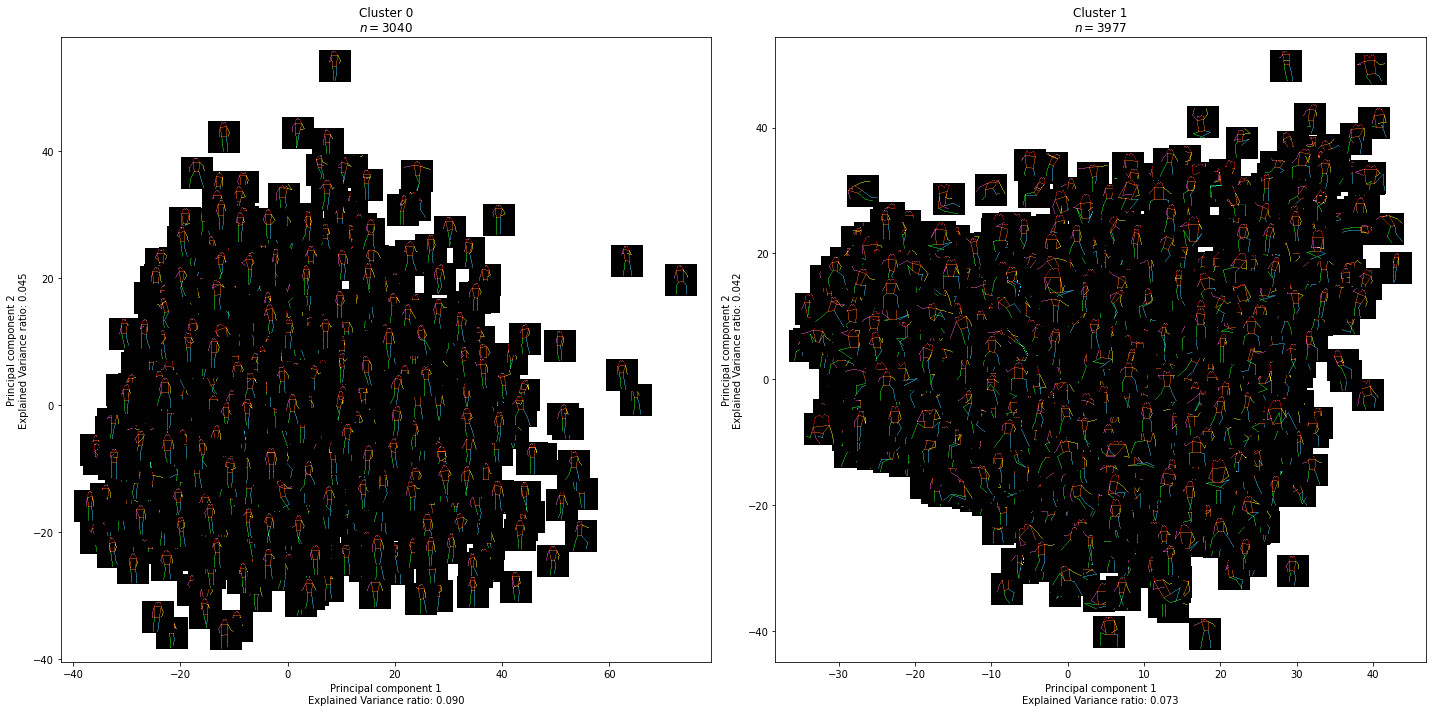

In [10]:
""" Visualizing the clusters with PCA"""
visualize_clusters_pca(X, y, kmeans_full_model.labels_, fig_saving_path = FIG_SAVING_PATH)

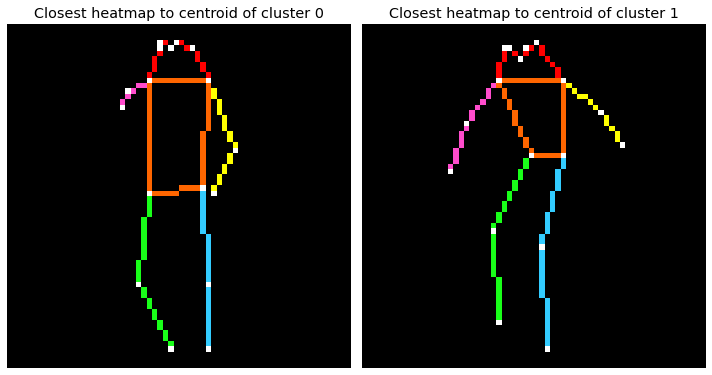

In [24]:
""" Finding gt heatmaps of centroids """
centroids_indices = []
centroids_gt_heatmaps = []

# Finding the indices
for centroid in centroids_full:
    for i, x in enumerate(StandardScaler().fit_transform(X)):
        if (x == centroid).all():
            centroids_indices.append(i)
            break

# Finding the gt heatmaps
for i in centroids_indices:
    centroids_gt_heatmaps.append(y[i])

# Showing and saving centroids
fig, axs = plt.subplots(1, 2, figsize = (10, 10))
for i, centroid in enumerate(centroids_gt_heatmaps):
    axs[i].imshow(draw_skeleton(turn_featuremaps_to_keypoints(centroid)))
    axs[i].set_title("Closest heatmap to centroid of cluster {}".format(i), size = "x-large")
    axs[i].axis("off")

plt.tight_layout()
plt.savefig(FIG_SAVING_PATH + "centroids_full_skeletons.png")
plt.show()